In [14]:
from tsModel import NeuralNet
import matplotlib.pyplot as plt
import torch
import networkModel
import numpy as np
import torch.nn as nn
import random
from torch.autograd import Variable
import time
from Wasserstein import Wasserstein

Text(0,0.5,'$X_t$')

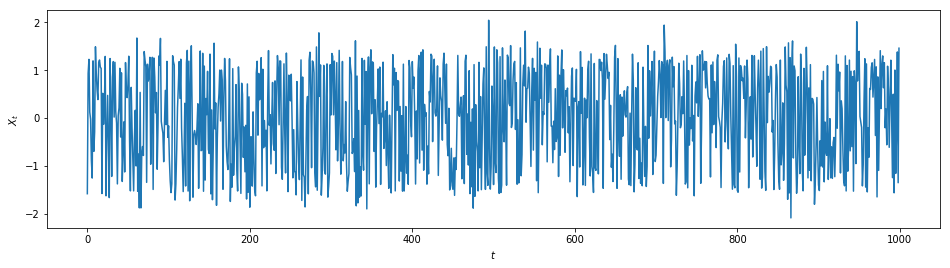

In [2]:
phi_a = [1.0, -0.5, 0.7, -0.4] ; phi_b = [0]
p = len(phi_a) ; q = len(phi_b)
dataSeed=0
N = 1000
data = NeuralNet(p=p, q=0, model_random_seed=8, random_seed=dataSeed, n_unit=[16,16,16,16], N=N, randomness="normal")
data = (data - data.mean())/data.std()
# 描画
plt.figure(figsize=(16,4))
plt.plot(data)
plt.xlabel("$t$")
plt.ylabel("$X_t$")

In [3]:
import os
os.makedirs("parameters", exist_ok=True)
os.makedirs("parameters/experiment3/", exist_ok=True)

### 学習ハイパラメータ

In [4]:
# ネットワークのパラメータの初期値
generatorSeed = 0
predictorSeed = 0
# 学習データの食わせ方のシード
learningSeed = 0
# モデルの構造を決定するパラメータの一つ。過去に遡る時刻
hat_p = 4
hat_r = 4
# epoch回数
n_epochs = 100
# # GANの学習をする回数に対する、MSEによる学習回数の割合(epoch単位)
# learnRatio = 0.2
# バッチ学習のサンプルサイズ
batch_size = 32
# MultiTaskの正則化係数
lam = 1.0

### GPU or CPU

In [5]:
cuda = True if torch.cuda.is_available() else False
if cuda:
    print("GPUが使えます。")
    use_gpu = input('GPUを使いますか？ （Yes：1, No：0）  ----> ')
    cuda = bool(int(use_gpu))
else:
    print("GPUは使えません。CPUを使います。")
if cuda:
    gpu_id = input('使用するGPUの番号を入れてください　---> ')
    os.environ["CUDA_VISIBLE_DEVICES"] = gpu_id
device = torch.device('cuda:'+gpu_id if cuda else 'cpu')

GPUは使えません。CPUを使います。


### networkの定義

In [6]:
torch.manual_seed(predictorSeed)
generator = networkModel.FullConnectGenerator(input_size=hat_r+1).to(device)
torch.manual_seed(predictorSeed)
predictor = networkModel.Predictor(input_size=hat_p+1).to(device)

### データの整形

In [7]:
trainData = torch.tensor(data[:900], dtype=torch.float).to(device)
valData = torch.tensor(data[900:], dtype=torch.float).to(device)

In [8]:
def makeMatrix(data, hat_p):
    data = data.view(1,-1)
    return torch.cat([data[:,i:i+hat_p+1] for i in range(data.shape[1]-hat_p)],dim=0)
trainMatrix = makeMatrix(trainData, hat_p=hat_p)
valMatrix = makeMatrix(valData, hat_p=hat_p)

### 事前学習

In [9]:
paramPath_pre = "parameters/experiment2/Predictor_pre.pth"
predictor.load_state_dict(torch.load(paramPath_pre)) 

<All keys matched successfully>

### 最適化

In [10]:
optimizer_G = torch.optim.RMSprop(params=generator.parameters(), lr=0.01)
optimizer_F = torch.optim.Adam(params=predictor.parameters(), lr=0.001)

### 損失

In [11]:
# from scipy.stats import norm  # 正規分布

# class Wasserstein:
    
#     def __init__(self, N:int, device=torch.device(type='cpu')):
#         self.N = N
#         self.device = device
#         self.phi = torch.tensor(norm.ppf(q=np.arange(self.N+1)/N, loc=0, scale=1)).to(self.device)
#         self.erf = torch.erf(self.phi/np.sqrt(2))
#         self.expo = torch.exp(-self.phi**2/2)
#         self.erf_diff = self.erf[1:] - self.erf[:-1]
#         self.expo_diff = (self.expo[1:] - self.expo[:-1])/np.sqrt(2*np.pi)
#         self.erf_sum = self.erf[1:] + self.erf[:-1]
#         self.expo_sum = (self.expo[1:] + self.expo[:-1])/np.sqrt(2*np.pi)
    
#     def dist(self, x):
#         x = x.view(self.N)
#         usual = x*self.erf_diff + self.expo_diff
#         unusual = (x*torch.erf(x/np.sqrt(2)) + torch.exp(-x**2/2)/np.sqrt(2*np.pi))*2 - x*self.erf_sum - self.expo_sum
#         ret = 0
#         for n in range(self.N):
#             if self.phi[n]>x[n]:
#                 ret -= usual[n]
#             elif x[n]>self.phi[n+1]:
#                 ret += usual[n]
#             else:
#                 ret += unusual[n]
#         return ret

In [15]:
mseLoss = nn.MSELoss().to(device)
wasserstein = Wasserstein(N = batch_size, device=device)
val_wasserstein = Wasserstein(N=valMatrix.shape[0], device=device)

In [16]:
# グラフ描画用
loss_Wasserstein_curve = []
loss_mse_curve = []
val_loss_Wasserstein_curve = []
val_loss_mse_curve = []
# タイマー
start = time.time()
# 学習データの食わせ方
random.seed(a=learningSeed)
# epochのflossのの最小値を保管
min_floss=np.inf
# モデルパラメータの保存先
paramPath_G = "parameters/experiment3/FullConnectGenerator.pth"
paramPath_F = "parameters/experiment3/Predictor.pth"

for epoch in range(1, n_epochs+1):
    
    loss_Wasserstein = 0
    loss_mse = 0
    l=list(range(trainMatrix.shape[0]-batch_size))
    batch_sample = random.sample(l, len(l))
    for i, batch in enumerate(batch_sample):
        sample = trainMatrix[batch : batch+batch_size]
        X = sample[:,:-1]
        Y = sample[:,-1:]
        
        train_G_input = sample
        train_G_output = generator(train_G_input)
        train_F_input = torch.cat([train_G_output, X], dim=1)
        train_F_output = predictor(train_F_input)
        
        wasloss = wasserstein.dist(x=train_G_output)
        mseloss = mseLoss(train_F_output, Y)
        loss = wasloss + mseloss*lam
        loss_Wasserstein += wasloss.item()
        loss_mse += mseloss.item()
        loss.backward()# 勾配をとる
        optimizer_G.step()
        optimizer_F.step()
        optimizer_G.zero_grad()
        optimizer_F.zero_grad()
    loss_Wasserstein_curve.append(loss_Wasserstein/(i+1))
    loss_mse_curve.append(loss_mse/(i+1))
    
    val_G_input = valMatrix
    Y = valMatrix[:,-1:]
    X = valMatrix[:,:-1]
    val_G_output = generator(val_G_input)
    val_F_input = torch.cat([val_G_output, X], dim=1)
    val_F_output = predictor(val_F_input)
    val_loss_Wasserstein_curve.append(val_wasserstein.dist(x=val_G_output).item())
    val_loss_mse_curve.append(mseLoss(val_F_output, Y).item())
    
    if val_loss_Wasserstein_curve[-1] + val_loss_mse_curve[-1]*lam < min_floss:
        min_floss = val_loss_Wasserstein_curve[-1] + val_loss_mse_curve[-1]*lam
        torch.save(generator.state_dict(), paramPath_G)
        torch.save(predictor.state_dict(), paramPath_F)
        print("epoch：{0}/{1}   val_loss_Wasserstein：{2: .4g}  val_loss_mse:{3: .4g}   経過時間：{4: .1f}秒　　saved".format(epoch, n_epochs, val_loss_Wasserstein_curve[-1], val_loss_mse_curve[-1], time.time()-start))
        
    
    if epoch % 5 == 0 and min_floss != val_loss_Wasserstein_curve[-1] + val_loss_mse_curve[-1]*lam:
        print("epoch：{0}/{1}   val_loss_Wasserstein：{2: .4g}  val_loss_mse:{3: .4g}   経過時間：{4: .1f}秒".format(epoch, n_epochs, val_loss_Wasserstein_curve[-1], val_loss_mse_curve[-1], time.time()-start))

epoch：1/100   val_loss_Wasserstein： 0.7813  val_loss_mse: 0.03993   経過時間： 3.7秒　　saved
epoch：2/100   val_loss_Wasserstein： 0.7769  val_loss_mse: 0.03202   経過時間： 7.8秒　　saved
epoch：3/100   val_loss_Wasserstein： 0.7838  val_loss_mse: 0.02328   経過時間： 12.3秒　　saved
epoch：4/100   val_loss_Wasserstein： 0.7872  val_loss_mse: 0.01114   経過時間： 15.8秒　　saved
epoch：5/100   val_loss_Wasserstein： 0.7885  val_loss_mse: 0.005745   経過時間： 21.4秒　　saved
epoch：9/100   val_loss_Wasserstein： 0.7886  val_loss_mse: 0.005604   経過時間： 39.2秒　　saved
epoch：10/100   val_loss_Wasserstein： 0.7925  val_loss_mse: 0.01246   経過時間： 43.9秒
epoch：12/100   val_loss_Wasserstein： 0.7837  val_loss_mse: 0.007255   経過時間： 52.8秒　　saved
epoch：15/100   val_loss_Wasserstein： 0.7886  val_loss_mse: 0.006331   経過時間： 65.8秒


KeyboardInterrupt: 

In [ ]:
plt.plot(loss_Wasserstein_curve)
plt.plot(val_loss_Wasserstein_curve)
# plt.xlim(0,10)
# plt.ylim(0,100)

In [ ]:
plt.plot(loss_mse_curve)
plt.plot(val_loss_mse_curve)
# plt.xlim(400,500)
# plt.ylim(0,1)